# ANOMALY_DETECTION for RENergetic Forecasters

# ON_FORECAST ONLY

> ## use of Isolation Forest Algorithm for anomaly detection

> ### daniele baranzini AI Operator (03/06/22)

>
# Time series 'model_s4_v_090122'   
### Algorithm: Least Angle Regression
(Machine Learning model)



### total time period copvered by model: 15-Aug-2020 -> 09 Nov 2020 window 


##### test set performce (07-Nov-2020 -> 09 Nov 2020 window)
>Test RMSE:    0.109  
>Test MAPE:    0.043   
>Correlation:  0.872    
>R-squared:    0.761

#### target feature: MW (thermic)
#### exogenous features: m3/h, Series, Month, 'Day

## requirements

In [1]:
# pip install xlrd                                  #once
# !pip install --user pycaret==2.3.3                #once          

In [2]:
#some dependncies
import pip
import pandas as pd
import numpy as np
import os

CURR_DIR = os.getcwd()                              #check working directory
print(CURR_DIR)

C:\Users\DANIELE\anaconda3\envs\PyCaret_RENergetic_2022_v01\lib\site-packages\_distutils_hack\__init__.py:36: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


C:\Users\DANIELE\anaconda3\envs\PyCaret_ANOMALY_TEST_s4_model


In [3]:
# !pip list                                         #check versions

>
## anomaly detection over predictions of a loaded model

### generate future data for a preiction estimator

#### past data enegineering

In [4]:
# read csv file
data = pd.read_excel('TEST_1b - for bktst.xls')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data['Date']=pd.to_datetime(data['date'])
data.set_index('Date',drop=False,inplace=True)
data=data[['Date','MW','m3_h']]
# data

In [5]:
data['MW_MA12'] = data['MW'].rolling(12).mean()                   # 12 month moving average of MW
# data['m3_h_MA12'] = data['m3_h'].rolling(12).mean()             # 12 month moving average of m3_h
# data

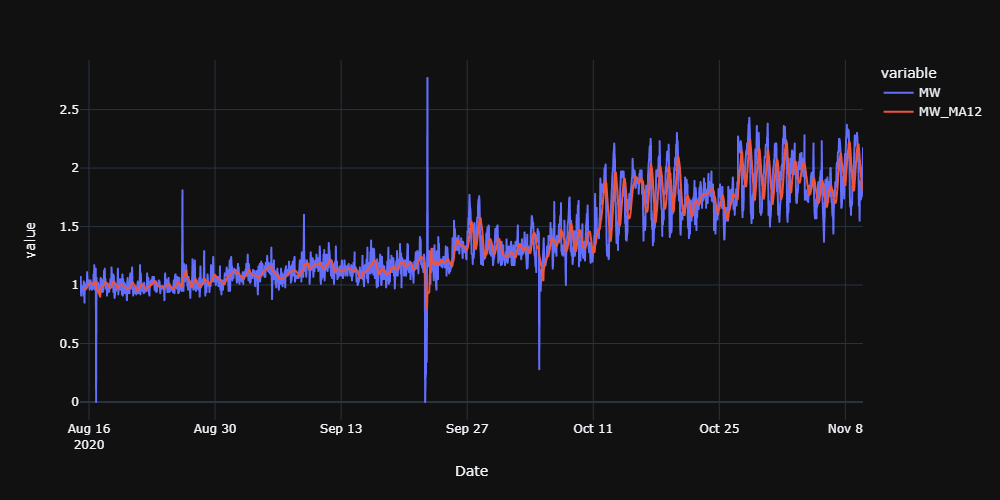

In [6]:
# plot the data and MA
import plotly.express as px
fig=px.line(data,x=data['Date'],y=['MW','MW_MA12'], template = 'plotly_dark')

fig.show('png',width=1000)

In [7]:
#extract year, month, day, hour from Date (transformed to_datetime previously)
data['Year']=data['Date'].dt.year
data['Month']=data['Date'].dt.month
data['Day']=data['Date'].dt.day
data['Hour']=data['Date'].dt.hour+1

In [8]:
# data

In [9]:
data=data[['Month','Day','Hour','m3_h','MW']]                     #reorder columns with [['1','2','3']] code
# data-

#### generating expected values for m3_h for 4 days projections (datetime is instead automatically generated)

In [10]:
# generating random component for future m3_h 
# (it is: Array of Random Gaussian Values - https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/)

from numpy.random import seed
from numpy.random import randn
seed(0)
rdm=randn(96)

# rdm

In [11]:
#extracting from pasta data on m3_h field
m3_h=pd.read_csv('m3_h_PROJECTION.csv')
new_m3_h=m3_h['m3_h']+rdm
new_m3_h.reset_index(drop=True,inplace=True)
new_m3_h=pd.DataFrame(new_m3_h)

new_m3_h

,m3_h
0,116.364052
1,103.800157
2,98.678738
3,109.440893
4,111.967558
...,...
91,104.522445
92,103.808275
93,105.776639
94,105.156366


In [12]:
#alternative generation for m3_h field
# new_m3_h=data['m3_h'].iloc[:96]+rdm
# new_m3_h.reset_index(drop=True,inplace=True)
# new_m3_h=pd.DataFrame(new_m3_h)

# new_m3_h

In [13]:
future_dates=pd.date_range(start='2020-11-10',periods=96,freq='H')        #4 days (96 hours) temporal forward prediction
# future_dates

future_df = pd.DataFrame()
future_df['Month']=[i.month for i in future_dates]
future_df['Day']=[i.day for i in future_dates]    
future_df['Series']=np.arange(2089,(2089+len(future_dates)))
future_df['m3_h']=new_m3_h['m3_h']                             #presently the copy of m3_h at test set (7-9 nov=3 days or 72 hours exactly) applies as m3_h estimate...\
                                                                          #note:the planned supply (or a forecasted consumption) of m3_h could be the estimate to enter for forward simulation...\
                                                                          #in particular, a sensistivy analysis can be performed by "simulating" the likely impact of changes in m3_h values in tems of MW savings (especially for nightly hours reduction of m3_h levels...e.g., a drop of 0.5 m3_h value on averge betweeen 3am and 5am,...in tyhis case energy manager would advise issues to alter m3_h in the night...).   
future_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   96 non-null     int64  
 1   Day     96 non-null     int64  
 2   Series  96 non-null     int32  
 3   m3_h    96 non-null     float64
dtypes: float64(1), int32(1), int64(2)
memory usage: 2.8 KB


### load a pre-trained model...to score a fh prediction

#### activate pycaret.regression

In [14]:
from pycaret.regression import *

In [15]:
loaded_best_model=load_model('model_s4_090122')      #load model...
loaded_best_model

Transformation Pipeline and Model Successfully Loaded


Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(features_todrop=['Hour'],
                                      ml_usecase='regression',
                                      numerical_features=['m3_h', 'Series',
                                                          'Month', 'Day'],
                                      target='MW')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catago...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'), ('dummy', Dummify(target='MW')),
                (

In [16]:
unseen_data=predict_model(loaded_best_model,data=future_df)       #this |predict_model| generates the label which to detect anomaly on

>
## ANOMALY DETECTION ON 4 DAYS PREDICTIONS

>
### detection of expected anomalies on the preditions

In [17]:
from pycaret.anomaly import *

### set up

In [18]:
anomaly_setup=setup(unseen_data,session_id=1235)

,Description,Value
0,session_id,1235
1,Original Data,"(96, 5)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,2
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(96, 8)"
9,CPU Jobs,-1


### anomaly detection models available 

In [19]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


### train isolation forest model: iforest

In [20]:
trained_iforest=create_model('iforest',fraction=0.09)

In [21]:
iforest_results=assign_model(trained_iforest)
iforest_results

,Month,Day,Series,m3_h,Label,Anomaly,Anomaly_Score
0,11,10,2089,116.364052,2.042634,0,-0.012334
1,11,10,2090,103.800157,1.850991,0,-0.039364
2,11,10,2091,98.678738,1.771575,0,-0.049765
3,11,10,2092,109.440893,1.931670,0,-0.050624
4,11,10,2093,111.967558,1.967581,0,-0.060884
...,...,...,...,...,...,...,...
91,11,13,2180,104.522445,1.829664,0,-0.106190
92,11,13,2181,103.808275,1.816706,0,-0.094006
93,11,13,2182,105.776639,1.844198,0,-0.089338
94,11,13,2183,105.156366,1.832655,0,-0.086864


#### check anomalies on list

In [22]:
iforest_results[iforest_results['Anomaly']==1].head(5)

,Month,Day,Series,m3_h,Label,Anomaly,Anomaly_Score
9,11,10,2098,121.210599,2.096012,1,0.014297
14,11,10,2103,82.443863,1.500495,1,0.035890
16,11,10,2105,83.294079,1.508937,1,0.026403
38,11,11,2127,90.312673,1.621547,1,0.062949
59,11,12,2148,134.637259,2.298889,1,0.028652


## plot anomalies across timeseries

In [23]:
#provide timedateindex for iforest_results dataframe
future_dates=pd.date_range(start='2020-11-10',periods=96,freq='H')
iforest_results.set_index(future_dates,drop=False,inplace=True)

In [24]:
iforest_results

,Month,Day,Series,m3_h,Label,Anomaly,Anomaly_Score
2020-11-10 00:00:00,11,10,2089,116.364052,2.042634,0,-0.012334
2020-11-10 01:00:00,11,10,2090,103.800157,1.850991,0,-0.039364
2020-11-10 02:00:00,11,10,2091,98.678738,1.771575,0,-0.049765
2020-11-10 03:00:00,11,10,2092,109.440893,1.931670,0,-0.050624
2020-11-10 04:00:00,11,10,2093,111.967558,1.967581,0,-0.060884
...,...,...,...,...,...,...,...
2020-11-13 19:00:00,11,13,2180,104.522445,1.829664,0,-0.106190
2020-11-13 20:00:00,11,13,2181,103.808275,1.816706,0,-0.094006
2020-11-13 21:00:00,11,13,2182,105.776639,1.844198,0,-0.089338
2020-11-13 22:00:00,11,13,2183,105.156366,1.832655,0,-0.086864


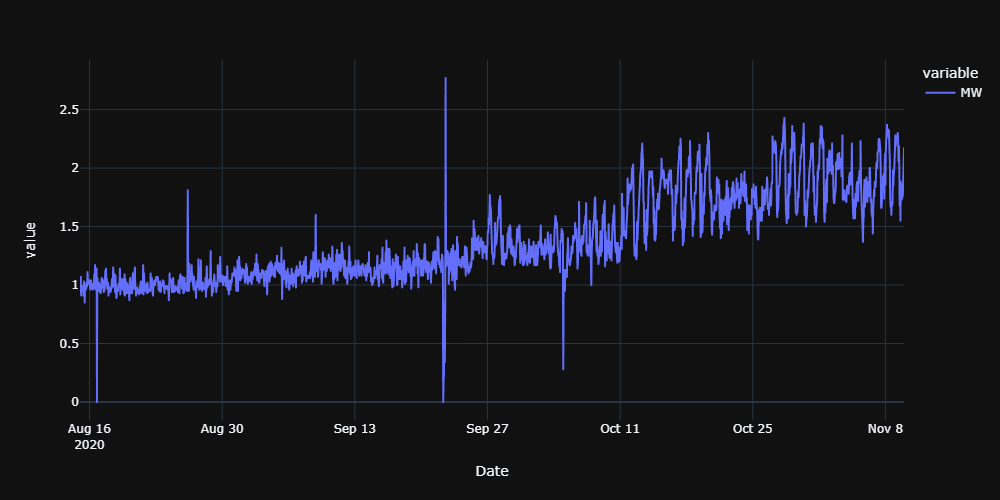

In [25]:
# read original dta (csv file: 'TEST_1b - for bktst.xls')
data = pd.read_excel('TEST_1b - for bktst.xls')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data['Date']=pd.to_datetime(data['date'])
data.set_index('Date',drop=False,inplace=True)
data=data[['Date','MW']]
# plot the data on MW field (original)
fig=px.line(data,x=data['Date'],y=['MW'], template = 'plotly_dark')

fig.show('png',width=1000)

In [26]:
#finalized dataset
Label=iforest_results[['Label','Anomaly']]                             #two brakets [['Label']] otherwise the data structure does not read it as column in a dataframe
finalized_dataset=data.append(Label,ignore_index=False)       #generate final dataframe made of 'MW' and 'Label' ..usefule for plotting predictions
# finalized_dataset[:]

#### integrated plot of MW, Label and anomaly points

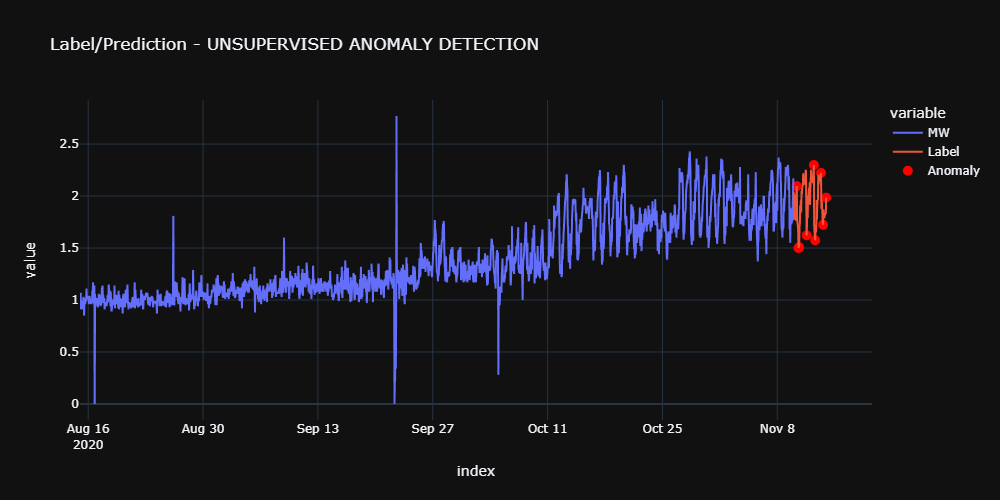

In [27]:
import plotly.graph_objects as go
#plot value on y-axis and date on x-axis
fig=px.line(finalized_dataset,x=finalized_dataset.index,y=['MW','Label'],title='Label/Prediction - UNSUPERVISED ANOMALY DETECTION',template='plotly_dark')
#create list of outlier_dates
outlier_dates=finalized_dataset[finalized_dataset['Anomaly']==1].index
#obtain y value of anomalies to plot
y_values=[finalized_dataset.loc[i]['Label'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates,y=y_values,mode='markers',name='Anomaly',marker=dict(color='red',size=10)))

fig.show('png',width=1000)

#### zoom in plot on test set only

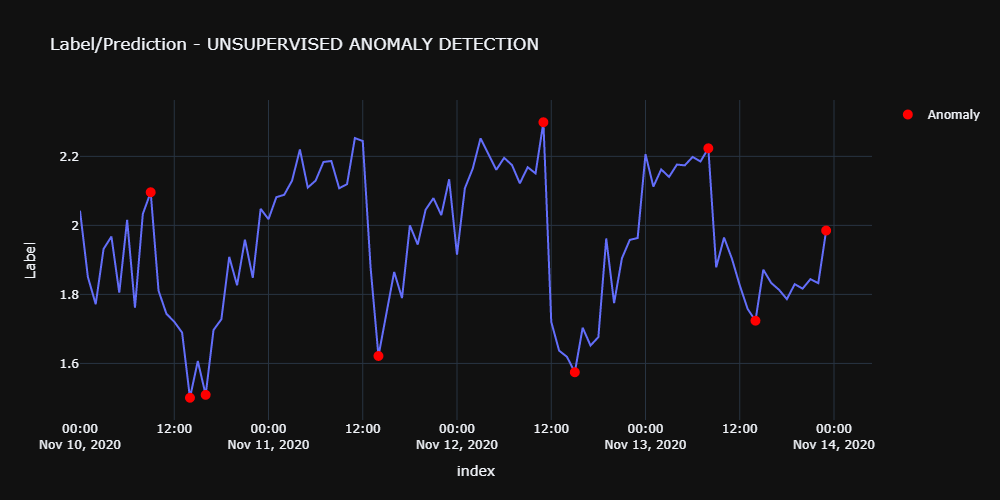

In [28]:
import plotly.graph_objects as go
#plot value on y-axis and date on x-axis
fig=px.line(iforest_results,x=iforest_results.index,y="Label",title='Label/Prediction - UNSUPERVISED ANOMALY DETECTION',template='plotly_dark')
#create list of outlier_dates
outlier_dates=iforest_results[iforest_results['Anomaly']==1].index
#obtain y value of anomalies to plot
y_values=[iforest_results.loc[i]['Label'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates,y=y_values,mode='markers',name='Anomaly',marker=dict(color='red',size=10)))

fig.show('png',width=1000)

#### original set

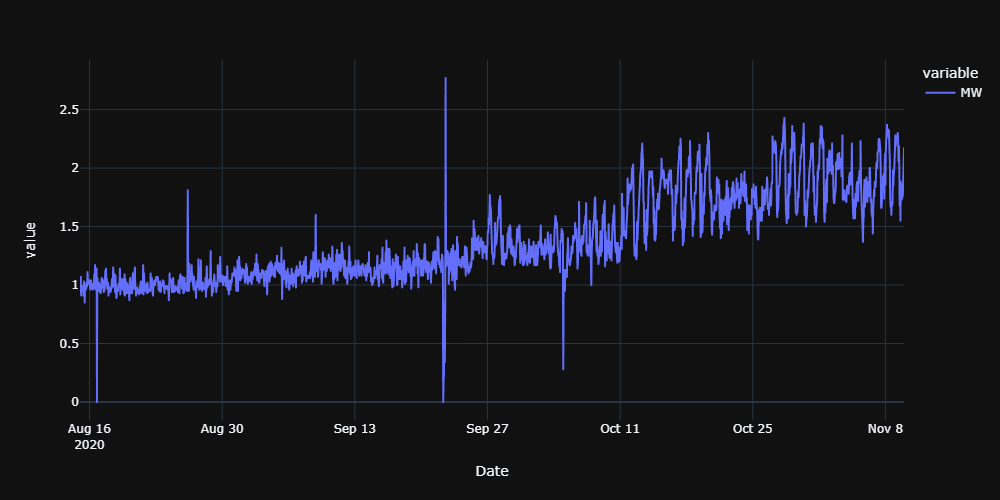

In [29]:
# read original dta (csv file: 'TEST_1b - for bktst.xls')
data = pd.read_excel('TEST_1b - for bktst.xls')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data['Date']=pd.to_datetime(data['date'])
data.set_index('Date',drop=False,inplace=True)
data=data[['Date','MW']]
# plot the data on MW field (original)
fig=px.line(data,x=data['Date'],y=['MW'], template = 'plotly_dark')

fig.show('png',width=1000)

In [30]:
# end